In [1]:
# Cell 1: verify dataset files and GPU
import os, sys
print("Inputs root:", "/kaggle/input")
for root, dirs, files in os.walk("/kaggle/input/wheat-plant-diseases/data"):
    # print only top-level directories and counts to keep output short
    break
print("Train/Valid/Test existence:")
print("train:", os.path.exists("/kaggle/input/wheat-plant-diseases/data/train"))
print("valid:", os.path.exists("/kaggle/input/wheat-plant-diseases/data/valid"))
print("test:", os.path.exists("/kaggle/input/wheat-plant-diseases/data/test"))
# GPU info
get_ipython().system_raw("nvidia-smi -L || true")
!nvidia-smi


Inputs root: /kaggle/input
Train/Valid/Test existence:
train: False
valid: False
test: False
/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Cell 2
!pip install -q timm

import os, time
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import timm
print("PyTorch version:", torch.__version__)
print("timm version:", timm.__version__)


PyTorch version: 2.8.0+cu126
timm version: 1.0.20


In [ ]:
# Cell 3
IMG_SIZE = 224
BATCH_SIZE = 16    # try 16; reduce to 8 if OOM
NUM_WORKERS = 4

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

DATA_ROOT = "/kaggle/input/wheat-plant-diseases/data"

train_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, "train"), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_ROOT, "valid"), transform=val_transform)
test_dataset  = datasets.ImageFolder(os.path.join(DATA_ROOT, "test"),  transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Classes:", train_dataset.classes)
print("Num classes:", len(train_dataset.classes))
print("Counts -> train/val/test:", len(train_dataset), len(val_dataset), len(test_dataset))


Classes: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']
Num classes: 15
Counts -> train/val/test: 13104 300 750


(-0.5, 223.5, 223.5, -0.5)

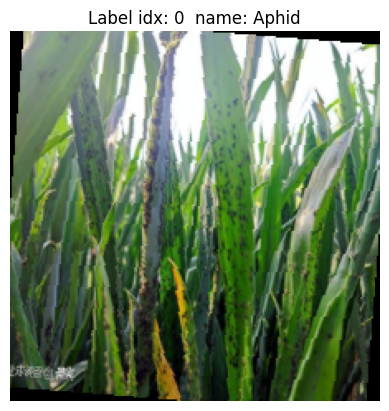

In [ ]:
# Cell 4
import matplotlib.pyplot as plt
img, label = train_dataset[0]
# unnormalize for display
img = img.numpy().transpose(1,2,0) * std + mean
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.title(f"Label idx: {label}  name: {train_dataset.classes[label]}")
plt.axis('off')


In [ ]:
# Cell 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "swin_base_patch4_window7_224"   # try this first
# model_name = "swin_small_patch4_window7_224"  # fallback if memory issues

model = timm.create_model(model_name, pretrained=True, num_classes=len(train_dataset.classes))
model.to(device)
print(model_name, "created. Params:", sum(p.numel() for p in model.parameters())//1_000_000, "M")


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

swin_base_patch4_window7_224 created. Params: 86 M


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)

# Define optional scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Define GradScaler for mixed-precision training
scaler = torch.amp.GradScaler('cuda')

In [ ]:
# Cell 7
import copy
from tqdm.notebook import tqdm

num_epochs = 8  # change as needed
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
save_path = "/kaggle/working/wheat_swin_best.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [train]")
    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_correct += (preds == labels).sum().item()
        running_total += images.size(0)

        loop.set_postfix(loss=running_loss/running_total, acc=100.*running_correct/running_total)

    epoch_loss = running_loss / running_total
    epoch_acc  = 100. * running_correct / running_total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * images.size(0)
            val_correct += (preds == labels).sum().item()
            val_total += images.size(0)
    val_loss = val_loss / val_total
    val_acc = 100. * val_correct / val_total

    print(f"Epoch {epoch+1} train_loss: {epoch_loss:.4f} train_acc: {epoch_acc:.2f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.2f}")

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    # checkpoint best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, save_path)
        print(f"Saved best model (val_acc: {val_acc:.2f}) -> {save_path}")

# load best weights after training
model.load_state_dict(best_model_wts)
print("Training complete. Best val_acc:", best_val_acc)


Epoch 1/8 [train]:   0%|          | 0/819 [00:00<?, ?it/s]

/tmp/ipykernel_19/3889030821.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 train_loss: 0.6334 train_acc: 79.85 | val_loss: 0.9659 val_acc: 81.67
Saved best model (val_acc: 81.67) -> /kaggle/working/wheat_swin_best.pth


Epoch 2/8 [train]:   0%|          | 0/819 [00:00<?, ?it/s]

Epoch 2 train_loss: 0.2884 train_acc: 90.25 | val_loss: 0.7051 val_acc: 87.67
Saved best model (val_acc: 87.67) -> /kaggle/working/wheat_swin_best.pth


Epoch 3/8 [train]:   0%|          | 0/819 [00:00<?, ?it/s]

Epoch 3 train_loss: 0.1882 train_acc: 93.28 | val_loss: 0.6498 val_acc: 87.67


Epoch 4/8 [train]:   0%|          | 0/819 [00:00<?, ?it/s]

Epoch 4 train_loss: 0.1458 train_acc: 94.76 | val_loss: 0.5523 val_acc: 92.33
Saved best model (val_acc: 92.33) -> /kaggle/working/wheat_swin_best.pth


Epoch 5/8 [train]:   0%|          | 0/819 [00:00<?, ?it/s]

Epoch 5 train_loss: 0.1110 train_acc: 95.86 | val_loss: 0.6820 val_acc: 90.33


Epoch 6/8 [train]:   0%|          | 0/819 [00:00<?, ?it/s]

Epoch 6 train_loss: 0.0894 train_acc: 96.37 | val_loss: 0.5881 val_acc: 92.00


Epoch 7/8 [train]:   0%|          | 0/819 [00:00<?, ?it/s]

Epoch 7 train_loss: 0.0758 train_acc: 96.73 | val_loss: 0.6101 val_acc: 93.33
Saved best model (val_acc: 93.33) -> /kaggle/working/wheat_swin_best.pth


Epoch 8/8 [train]:   0%|          | 0/819 [00:00<?, ?it/s]

Epoch 8 train_loss: 0.0612 train_acc: 97.13 | val_loss: 0.6056 val_acc: 93.33
Training complete. Best val_acc: 93.33333333333333


In [ ]:
# Cell 8
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device, non_blocking=True)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Test Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)) * 100)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))


Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Test Accuracy: 91.60000000000001

Classification report:
                           precision    recall  f1-score   support

               aphid_test       0.96      1.00      0.98        50
          black_rust_test       0.97      0.78      0.87        50
               blast_test       0.96      1.00      0.98        50
          brown_rust_test       0.82      1.00      0.90        50
     common_root_rot_test       1.00      1.00      1.00        50
fusarium_head_blight_test       1.00      1.00      1.00        50
             healthy_test       1.00      0.08      0.15        50
         leaf_blight_test       0.93      1.00      0.96        50
              mildew_test       1.00      1.00      1.00        50
                mite_test       1.00      0.94      0.97        50
            septoria_test       1.00      1.00      1.00        50
                smut_test       1.00      1.00      1.00        50
            stem_fly_test       1.00      1.00      1.00        50
    

In [ ]:
!pip install -q grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


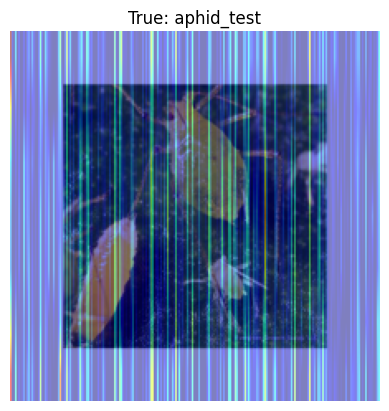

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import matplotlib.pyplot as plt

# Make sure model is on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# For Swin, target layer = last norm layer of last block
target_layer = model.layers[-1].blocks[-1].norm1

# ✅ no use_cuda argument
cam = GradCAM(model=model, target_layers=[target_layer])

# Select one test image
image, label = test_dataset[10]
input_tensor = image.unsqueeze(0).to(device)

# CAM calculation
targets = [ClassifierOutputTarget(label)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

# Prepare original image for overlay (unnormalize)
rgb_img = image.permute(1, 2, 0).cpu().numpy()
rgb_img = (rgb_img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
rgb_img = np.clip(rgb_img, 0, 1)

# Overlay CAM on image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title(f"True: {test_dataset.classes[label]}")
plt.axis("off")
plt.show()
